<a href="https://colab.research.google.com/github/victornator25/Data-Science/blob/main/ProyectoFinal_DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Uso de datos de rangos bateo de jugadores de la MLB de la temporada 2022 para predicción qué equipo ganará la Serie Mundial si se conservan los mismos bateadores.

Datos obtenidos de Kaggle: https://www.kaggle.com/datasets/vivovinco/2022-mlb-player-stats


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import codecs

path='2022 MLB Player Stats - Batting.csv'
with codecs.open(path, 'r', 'utf-8', 'ignore') as f:
    df = pd.read_csv(f,sep=';')

#df=df.sort_values('SLG',ascending=False)
df.head()

,Rk,Name,Age,Tm,Lg,G,PA,AB,R,H,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,1,CJAbrams*,21,TOT,NL,90,302,284,33,70,...,0.280,0.324,0.604,76,92,5,9,2,2,0
1,2,CJAbrams*,21,SDP,NL,46,139,125,16,29,...,0.285,0.320,0.605,77,40,4,6,2,2,0
2,3,CJAbrams*,21,WSN,NL,44,163,159,17,41,...,0.276,0.327,0.603,75,52,1,3,0,0,0
3,4,AlbertAbreu,26,TOT,AL,1,0,0,0,0,...,0.000,0.000,0.000,0,0,0,0,0,0,0
4,5,AlbertAbreu,26,KCR,AL,1,0,0,0,0,...,0.000,0.000,0.000,0,0,0,0,0,0,0


#Exploración de Datos

In [2]:
#Para saber todas las columnas que tenemos
cols=df.columns.tolist()
print(cols)

['Rk', 'Name', 'Age', 'Tm', 'Lg', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB']


#Donde:

Rk : Rank

Name : Player name

Age : Player's age

Tm : Team

Lg : League

G : Games played

PA : Plate appearances

AB : At bats

R : Runs scored/allowed

H : Hits/hits allowed

2B : Doubles hit/allowed

3B : Triples hit/allowed

HR : Home runs hit/allowed

RBI : Runs batted in

SB : Stolen bases

CS : Caught stealing

BB : Bases on balls/walks

SO : Strikeouts

BA : Hits/at bats

OBP : (H + BB + HBP) / (AB + BB + HBP + SF)

SLG : Total bases/at bats or (1B + 2 2B + 3 3B + 4 * HR) / AB

OPS : On-base + Slugging percentages

OPS+ : 100 * (OBP / logOBP + SLG / logSLG - 1)

TB : Total bases

GDP : Double plays grounded into

HBP : Times hit by a pitch

SH : Sacrifice hits

SF : Sacrifice flies

IBB : Intentional bases on balls

<ipython-input-3-dfd89de42dae>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


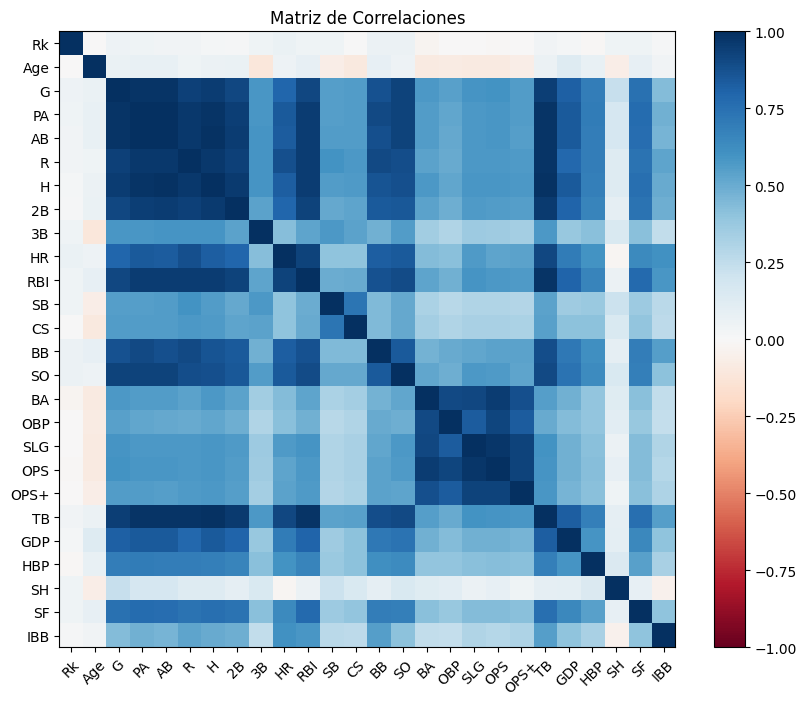

In [3]:
correlation_matrix = df.corr()

# Visualizar la matriz de correlaciones
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Matriz de Correlaciones')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

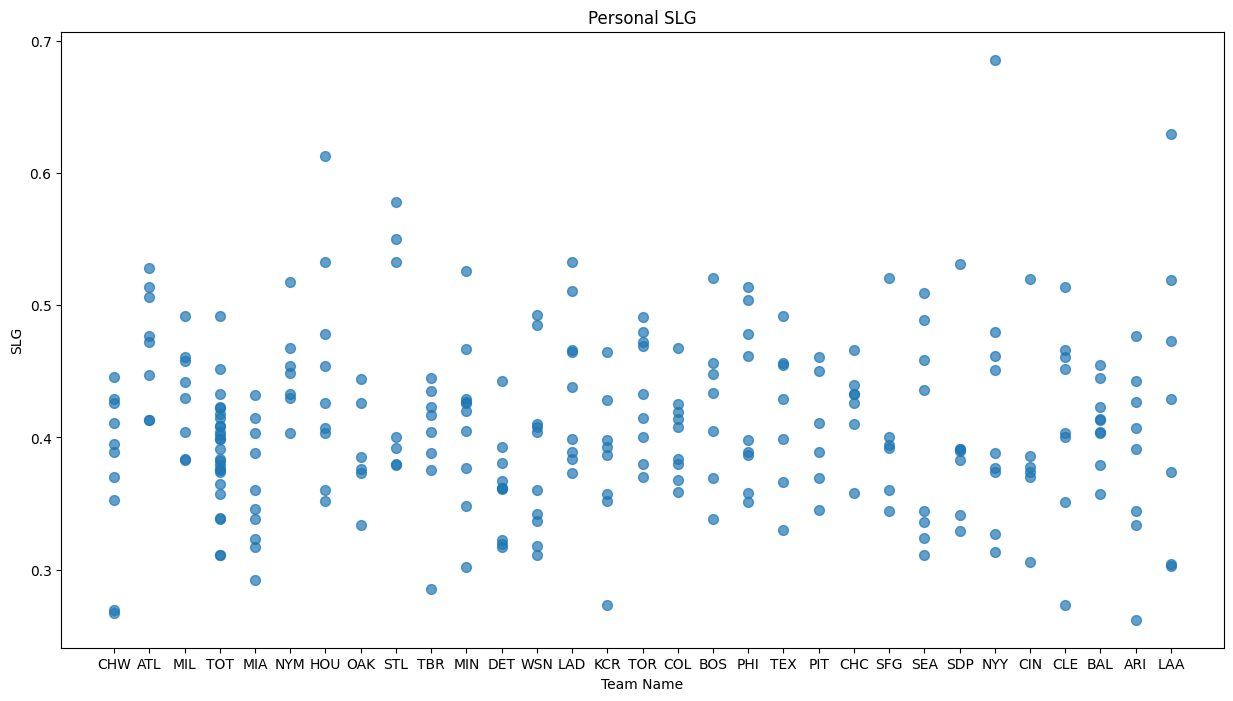

In [ ]:
plt.figure(figsize=(15, 8))
plt.scatter(df['Tm'], df['SLG'], alpha=0.7, s=50)
plt.title("Personal SLG")
plt.xlabel("Team Name")
plt.ylabel("SLG")
plt.show()

#Limpieza de los datos



In [ ]:
# Verificar si existen NaNs en el dataframe
nan_counts = df.isnull().sum()

# Imprimir las columnas con valores NaN
columns_with_nan = nan_counts[nan_counts > 0].index
print(f"Columnas con valores NaN: {columns_with_nan}")

Columnas con valores NaN: Index([], dtype='object')


El dataframe no contiene NaN's

In [ ]:
#Eliminar las filas con jugadores que tienen pocas apariciones al bat
df = df.drop(df[df['AB'] < 300].index)

In [ ]:
# Crear el nuevo DataFrame con las  primeras columnas + la columna de equipo


new_columns = ['Tm', 'R', '2B', 'H', '3B', 'HR', 'RBI', 'SB', 'SO', 'BA', 'OBP', 'SLG', 'TB',  'GDP']
# Se quita SO porque son strike outs y tambien TB,  agrego 3B
df_new = df[new_columns].copy()
df_f = df_new[~df_new['Tm'].str.contains('TOT')]

#para normalizar los datos
# Seleccionar las columnas numéricas
from sklearn.preprocessing import MinMaxScaler

columnas_numericas = df_f.select_dtypes(include=['int', 'float']).columns

# Crear un nuevo dataframe con las columnas reescaladas
df_r = df_f.copy()
scaler = MinMaxScaler()
df_r[columnas_numericas] = scaler.fit_transform(df_f[columnas_numericas])

#multiplicar por -1: SO, GDP ya que son strike outs y doubleplays por vez 
#que batearon
# Multiplicar por -1 los valores de la columna

df_r[['SO', 'GDP']] = df_r[['SO', 'GDP']].apply(lambda x: x * -1)

df_r.head()

,Tm,R,2B,H,3B,HR,RBI,SB,SO,BA,OBP,SLG,TB,GDP
5,CHW,0.593220,0.825,0.884892,0.0,0.241935,0.495495,0.000000,-0.461078,0.857143,0.755208,0.433962,0.604502,-0.730769
6,ATL,0.474576,0.425,0.460432,0.0,0.241935,0.270270,0.707317,-0.556886,0.610390,0.614583,0.356132,0.363344,-0.307692
7,MIL,0.576271,0.600,0.532374,0.0,0.500000,0.702703,0.195122,-0.796407,0.428571,0.338542,0.462264,0.572347,-0.423077
14,MIA,0.186441,0.275,0.273381,0.0,0.241935,0.261261,0.024390,-0.437126,0.415584,0.276042,0.297170,0.260450,-0.307692
32,NYM,0.677966,0.500,0.733813,0.0,0.645161,1.000000,0.121951,-0.568862,0.642857,0.619792,0.603774,0.736334,-0.653846


#Métodos de ML: Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Definir las columnas de características (X) y el objetivo (y)
#X = df_r.drop(['Tm'], axis=1)  # Excluir las columnas 'Tm'
y = df_r['Tm']
X = df_r[['R','H' ]]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

# Inicializar el modelo de Random Forest Classifier
model = RandomForestClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
print(f"Precisión del modelo: {accuracy}")

Precisión del modelo: 0.05670103092783505


In [ ]:
predictions

array(['NYY', 'ATL', 'DET', 'SDP', 'MIL', 'OAK', 'LAA', 'WSN', 'OAK',
       'WSN', 'CHW', 'CHW', 'NYY', 'NYY', 'SEA', 'KCR', 'BAL', 'LAD',
       'KCR', 'KCR', 'ATL', 'NYM', 'CHC', 'PIT', 'TEX', 'BOS', 'NYY',
       'SEA', 'BOS', 'SDP', 'LAA', 'BOS', 'HOU', 'HOU', 'KCR', 'NYM',
       'MIL', 'SEA', 'LAA', 'CHW', 'OAK', 'TOR', 'CHW', 'TEX', 'STL',
       'NYM', 'BOS', 'WSN', 'LAD', 'STL', 'HOU', 'CHW', 'HOU', 'BAL',
       'HOU', 'LAD', 'MIL', 'OAK', 'NYY', 'WSN', 'HOU', 'DET', 'DET',
       'NYM', 'STL', 'PIT', 'DET', 'DET', 'LAA', 'TEX', 'LAA', 'ATL',
       'DET', 'MIL', 'NYM', 'BOS', 'BOS', 'SDP', 'BAL', 'KCR', 'LAA',
       'DET', 'LAD', 'DET', 'TBR', 'KCR', 'CHW', 'BOS', 'TEX', 'CHW',
       'SDP', 'BAL', 'ATL', 'BOS', 'SEA', 'WSN', 'BAL', 'DET', 'DET',
       'BAL', 'SEA', 'MIL', 'HOU', 'NYY', 'CHW', 'LAA', 'CHW', 'BOS',
       'KCR', 'DET', 'KCR', 'LAA', 'BAL', 'NYY', 'KCR', 'SEA', 'CHC',
       'LAD', 'MIL', 'KCR', 'CHW', 'TOR', 'CHC', 'NYM', 'SEA', 'HOU',
       'DET', 'BOS',

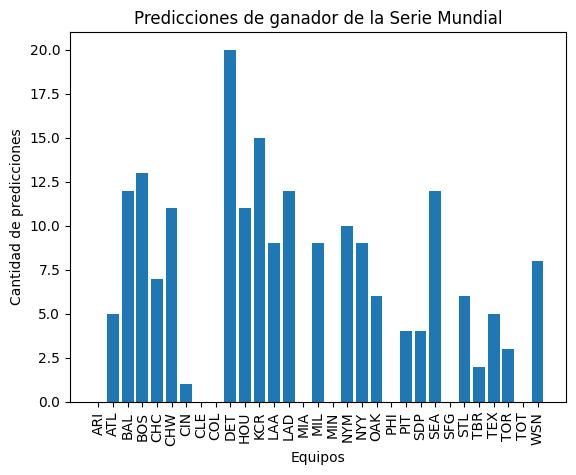

In [ ]:
# Obtener los nombres únicos de los equipos
unique_teams = np.unique(df_new['Tm'])

# Crear un diccionario para asignar un número único a cada equipo
team_mapping = {team: i for i, team in enumerate(unique_teams)}

# Mapear las predicciones a los números únicos de los equipos
mapped_predictions = [team_mapping[prediction] for prediction in predictions]

# Crear un gráfico de barras para visualizar las predicciones
fig, ax = plt.subplots()
ax.bar(unique_teams, np.bincount(mapped_predictions))
ax.set_xlabel('Equipos')
ax.set_ylabel('Cantidad de predicciones')
ax.set_title('Predicciones de ganador de la Serie Mundial')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Obtener los índices que ordenarían el arreglo en forma ascendente
sorted_indices = np.argsort(np.bincount(mapped_predictions))

# Seleccionar los 5 primeros índices en forma descendente
top_indices = sorted_indices[-6:][::-1]

# Obtener los valores correspondientes a los índices seleccionados
top_values = np.bincount(mapped_predictions)[top_indices]

print(top_values)


[20 15 13 12 12 12]


#Matriz de Confusión

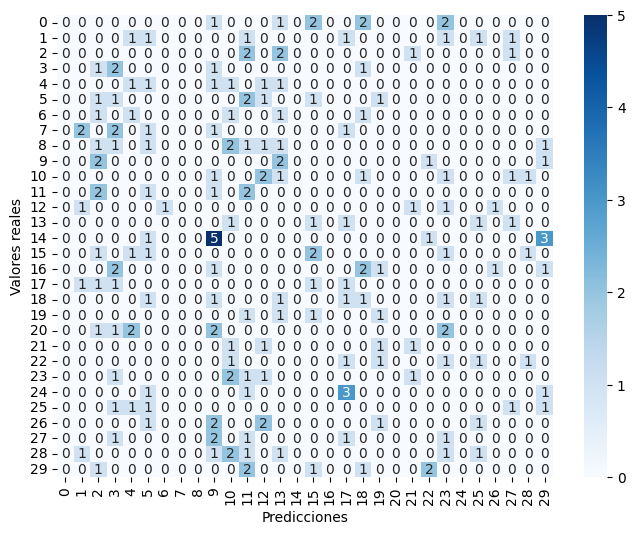

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Realizar predicciones sobre el conjunto de prueba
predictions = model.predict(X_test)
# Crear la matriz de confusión
confusion = confusion_matrix(y_test, predictions)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()

#Regresión Logística

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Modelo de Regresión Logística
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Predicciones en el conjunto de prueba
logreg_pred = logreg_model.predict(X_test)

# Evaluar el rendimiento utilizando la exactitud (accuracy)
logreg_accuracy = accuracy_score(y_test, logreg_pred)


print("Exactitud Regresión Logística:", logreg_accuracy)

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test)


Exactitud Regresión Logística: 0.05154639175257732


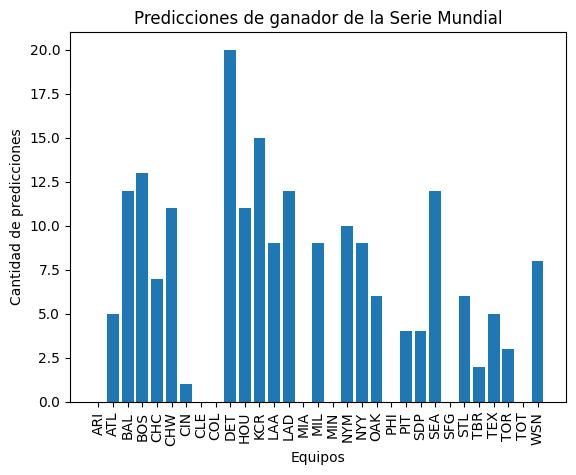

In [ ]:
# Obtener los nombres únicos de los equipos
unique_teams = np.unique(df_new['Tm'])

# Crear un diccionario para asignar un número único a cada equipo
team_mapping = {team: i for i, team in enumerate(unique_teams)}

# Mapear las predicciones a los números únicos de los equipos
mapped_predictions = [team_mapping[prediction] for prediction in predictions]

# Crear un gráfico de barras para visualizar las predicciones
fig, ax = plt.subplots()
ax.bar(unique_teams, np.bincount(mapped_predictions))
ax.set_xlabel('Equipos')
ax.set_ylabel('Cantidad de predicciones')
ax.set_title('Predicciones de ganador de la Serie Mundial')
plt.xticks(rotation=90)
plt.show()

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Dividir los datos en conjunto de entrenamiento y prueba
X = df_r.drop(['Tm'], axis=1)  # Características
y = df_r['Tm']  # Variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
predictions = svm.predict(X_test)

# Obtener el equipo con la mayor cantidad de predicciones
equipo_mejor = pd.Series(predictions).value_counts().idxmax()
print("El equipo que le irá mejor según las predicciones es:", equipo_mejor)

El equipo que le irá mejor según las predicciones es: BAL


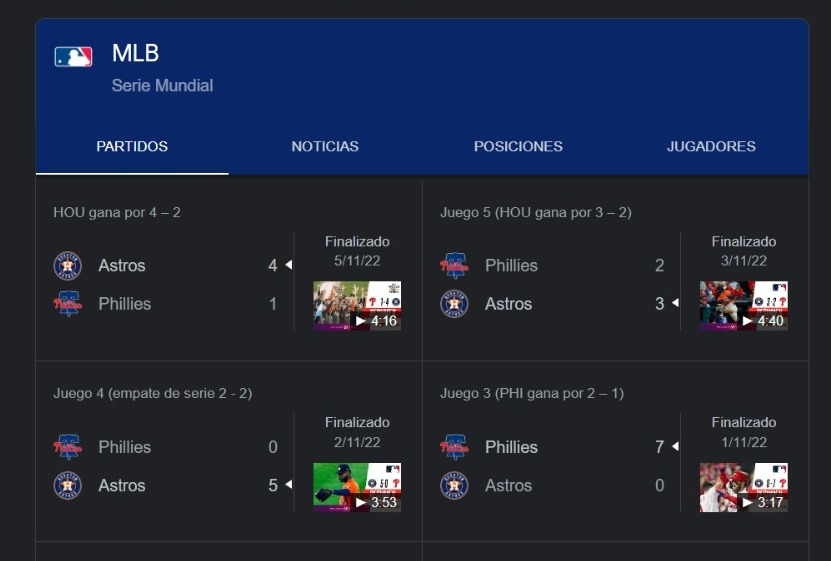

#Conclusiones:
Las predicciones en los deportes son difíciles de hacer y más en deportes de alto nivel como lo es la MLB. Además no basta con tener estadísticas de bateadores por separados. Para una predicción con más certeza y más elaborada sería bueno tener estadísticas de los pitcher también, además de un historial de sus juegos ganados históricamente.